In [1]:
% run __initialize.ipynb
import pyspark

In [77]:
import pyspark.sql.functions as F
from pyspark.sql.types import *

sdf= spark.read.option('header','true')\
    .option('inferSchema','true')\
    .csv('data/household_power_consumption.txt', sep=';')\
    .limit(1000)
sdf = sdf.select('Date','Time',
                 sdf.Global_active_power.cast(DoubleType()), 
                 sdf.Global_reactive_power.cast(DoubleType()))\
         .withColumn('bin', F.floor(F.monotonically_increasing_id()/100.))\
         .filter(F.rand() < 0.5)
         
sdf.registerTempTable('power')

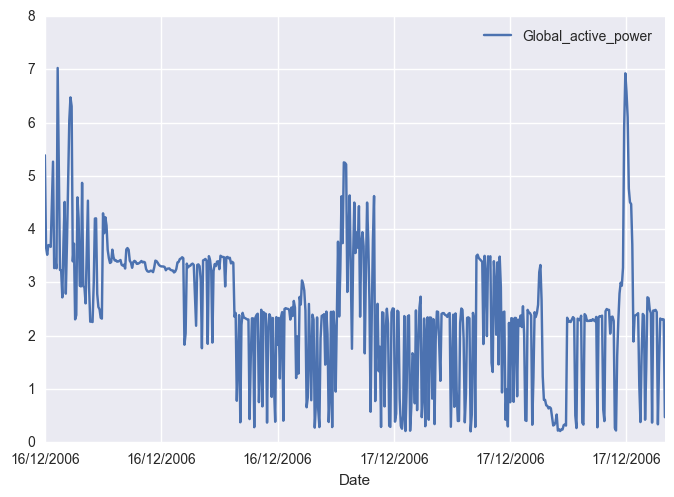

In [6]:
df = sdf.toPandas()
df.plot('Date','Global_active_power')

In [7]:
%config SQLConn.conn_object_name = 'spark'

In [8]:
%%readsql
SELECT *
FROM power
LIMIT 10

,Date,Time,Global_active_power,Global_reactive_power,bin
0,16/12/2006,17:27:00,5.388,0.502,0
1,16/12/2006,17:28:00,3.666,0.528,0
2,16/12/2006,17:29:00,3.520,0.522,0
3,16/12/2006,17:30:00,3.702,0.520,0
4,16/12/2006,17:31:00,3.700,0.520,0
5,16/12/2006,17:32:00,3.668,0.510,0
6,16/12/2006,17:34:00,4.448,0.498,0
7,16/12/2006,17:37:00,5.268,0.398,0
8,16/12/2006,17:40:00,3.270,0.152,0
9,16/12/2006,17:41:00,3.430,0.156,0


# Build Custom UDF functions

In [136]:
from spark_udfs import *

cols = ['Time','Global_active_power']
# functions we want to apply to groupby df
def max_time(df):
    return str(df.Time.max())
def min_power(df):
    return float(df.Global_active_power.min())
def fxn_with_args(df, a=1, b=2):
    return str((a,b))
fxns = [(max_time,StringType(),{}),
        (min_power,FloatType(),{}),
        (fxn_with_args,StringType(),{'a':1,'b':60})]
apply_to_fxns = [apply_py_fxn(fxn,t,*cols,**fxn_kwargs) for (fxn,t,fxn_kwargs) in fxns]
# apply to spark df
_sdf = sdf.groupBy('bin')
_sdf = _sdf.agg(*apply_to_fxns)
df = _sdf.toPandas()
df

{}
{}
{'a': 1, 'b': 60}


,bin,max_time,min_power,fxn_with_args
0,0,19:03:00,2.188,"(1, 60)"
1,1,20:43:00,3.188,"(1, 60)"
2,2,22:22:00,0.780,"(1, 60)"
3,3,23:59:00,0.376,"(1, 60)"
4,4,01:43:00,0.356,"(1, 60)"
5,5,03:23:00,0.206,"(1, 60)"
6,6,05:03:00,0.206,"(1, 60)"
7,7,06:39:00,0.224,"(1, 60)"
8,8,08:22:00,0.210,"(1, 60)"
9,9,10:02:00,0.222,"(1, 60)"


In [121]:
df = sdf.toPandas()
df.groupby('bin').Time.max(), df.groupby('bin').Global_active_power.min()

(bin
 0    19:03:00
 1    20:43:00
 2    22:22:00
 3    23:59:00
 4    01:43:00
 5    03:23:00
 6    05:03:00
 7    06:39:00
 8    08:22:00
 9    10:02:00
 Name: Time, dtype: object, bin
 0    2.188
 1    3.188
 2    0.780
 3    0.376
 4    0.356
 5    0.206
 6    0.206
 7    0.224
 8    0.210
 9    0.222
 Name: Global_active_power, dtype: float64)

# Misc

In [6]:
@spark_udf(MapType(StringType(), DoubleType()))
def exp_decay_values(ref_pt, past_events, decay):
    decay = float(decay)
    ref_pt = pd.to_datetime(ref_pt)
    df = pd.to_datetime(past_events)
    time_diff = (ref_pt - df).total_seconds()
    exp_time_diff = np.exp(-time_diff/decay)
    results = {}
    for k,func in agg_functions.items():
        results[k] = float(func(exp_time_diff))
    return results

pyspark.sql.types.Row

In [218]:
print(str(pd.DataFrame([Row(a=1,b=2), Row(a=6,b=4)],columns=['a','b'])))

   a  b
0  1  2
1  6  4


In [186]:
r = Row(Time = 'now', Val = 1)
list(r.asDict().keys())
r.__fields__

['Time', 'Val']

In [222]:
!ls

README.md               ds_powerpoint           ds_tools.py
__initialize.ipynb      ds_powerpoint.py        ds_tools.pyc
__pycache__             ds_powerpoint.pyc       ds_tree_interp.py
data                    ds_spark.ipynb          metastore_db
derby.log               ds_sql.py               template_explained.pptx
ds_plotting.py          ds_sql.pyc
ds_plotting.pyc         ds_tools.ipynb


In [227]:
from spark_udfs import *

In [187]:
@spark_udf(StringType())
def test_struct(test):
    for v in test:
        (v.Time, v.Global_active_power)
    col_names = list(v.asDict().keys())
    return str(pd.DataFrame(test, columns = col_names))


# df = sdf.limit(5).select(F.struct(col('Time'), col('Global_active_power'))\
#                     .alias('tup'))\
#                     .select(F.collect_list('tup').alias('tup_struct'))\
#                     .select(test_struct('tup_struct')).toPandas()

df = sdf.limit(5).select(F.struct(col('Time'), col('Global_active_power'))\
                    .alias('tup'))\
                    .select(F.collect_list('tup').alias('tup_struct'))\
                    .select(apply_to_group('tup_struct',1)).toPandas()
        
print(df.iloc[0][0])

Py4JJavaError: An error occurred while calling o4386.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 176.0 failed 1 times, most recent failure: Lost task 0.0 in stage 176.0 (TID 177, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark-2.1.0/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/usr/local/spark-2.1.0/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark-2.1.0/python/lib/pyspark.zip/pyspark/serializers.py", line 220, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/usr/local/spark-2.1.0/python/lib/pyspark.zip/pyspark/serializers.py", line 138, in dump_stream
    for obj in iterator:
  File "/usr/local/spark-2.1.0/python/lib/pyspark.zip/pyspark/serializers.py", line 209, in _batched
    for item in iterator:
  File "/usr/local/spark-2.1.0/python/lib/pyspark.zip/pyspark/worker.py", line 92, in <lambda>
    mapper = lambda a: udf(*a)
  File "/usr/local/spark-2.1.0/python/lib/pyspark.zip/pyspark/worker.py", line 70, in <lambda>
    return lambda *a: f(*a)
  File "<ipython-input-182-6634a3ec15fc>", line 20, in _apply_fxn
TypeError: 'int' object is not callable

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:144)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:87)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:796)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:796)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1944)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1958)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:935)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:934)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:275)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply$mcI$sp(Dataset.scala:2745)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2742)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2742)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2765)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:2742)
	at sun.reflect.GeneratedMethodAccessor104.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark-2.1.0/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/usr/local/spark-2.1.0/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark-2.1.0/python/lib/pyspark.zip/pyspark/serializers.py", line 220, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/usr/local/spark-2.1.0/python/lib/pyspark.zip/pyspark/serializers.py", line 138, in dump_stream
    for obj in iterator:
  File "/usr/local/spark-2.1.0/python/lib/pyspark.zip/pyspark/serializers.py", line 209, in _batched
    for item in iterator:
  File "/usr/local/spark-2.1.0/python/lib/pyspark.zip/pyspark/worker.py", line 92, in <lambda>
    mapper = lambda a: udf(*a)
  File "/usr/local/spark-2.1.0/python/lib/pyspark.zip/pyspark/worker.py", line 70, in <lambda>
    return lambda *a: f(*a)
  File "<ipython-input-182-6634a3ec15fc>", line 20, in _apply_fxn
TypeError: 'int' object is not callable

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:144)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:87)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:796)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:796)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [107]:
sdf.limit(5)\
    .select(F.struct(col('Time'), col('Global_active_power')).alias('test_array'))\
    .select(col('test_array')['Time'], col('test_array')['Global_active_power'])

DataFrame[test_array.Time: string, test_array.Global_active_power: double]

In [133]:
from pyspark.sql.functions import mean, hour, array

agg_functions = {'min': np.min, 'max': np.max, 'mean': np.mean, 'sum': np.sum, 'median': np.median}
DECAY_FACTOR = 60.*60

@spark_udf(MapType(StringType(), DoubleType()))
def exp_rolling(ref_pt, past_events, decay):
    decay = float(decay)
    ref_pt = pd.to_datetime(ref_pt)
    df = pd.to_datetime(past_events)
    time_diff = (ref_pt - df).total_seconds()
    exp_time_diff = np.exp(-time_diff/decay)
    results = {}
    for k,func in agg_functions.items():
        results[k] = float(func(exp_time_diff))
    return results

sdf2 = sdf.limit(500)\
    .groupby('bin')\
    .agg(F.max('Time').alias('ref_pt'), F.collect_list('Time').alias('time_array'), F.count('Time').alias('num_observations'))\
    .select('*', exp_rolling('ref_pt', 'time_array', F.lit(DECAY_FACTOR)).alias('exp_aggs'))\
    .select('*', *[col('exp_aggs')[i].alias('exp_aggs_' + i) for i in agg_functions.keys()])\
    .drop('exp_aggs')
#     .toPandas()
# select(exp_rolling(col('Date'),col('Global_active_power'))).toPandas()

In [8]:
sdf2.toPandas()

,bin,ref_pt,time_array,num_observations,exp_aggs_sum,exp_aggs_mean,exp_aggs_min,exp_aggs_max,exp_aggs_median
0,0,19:00:00,"[17:29:00, 17:30:00, 17:33:00, 17:34:00, 17:37...",45,23.863592,0.530302,2.194421e-01,1.0,0.480305
1,1,20:38:00,"[19:04:00, 19:05:00, 19:06:00, 19:08:00, 19:09...",46,21.325101,0.463589,2.087398e-01,1.0,0.416876
2,2,22:23:00,"[20:44:00, 20:46:00, 20:50:00, 20:51:00, 20:52...",44,21.280607,0.483650,1.920499e-01,1.0,0.400350
3,3,23:59:00,"[22:24:00, 22:25:00, 22:26:00, 22:28:00, 22:29...",51,25.474962,0.499509,3.903093e-11,1.0,0.488377
4,4,01:42:00,"[00:04:00, 00:06:00, 00:09:00, 00:11:00, 00:12...",50,25.574357,0.511487,1.952776e-01,1.0,0.460848
5,5,03:21:00,"[01:44:00, 01:45:00, 01:46:00, 01:47:00, 01:48...",49,24.472760,0.499444,1.985595e-01,1.0,0.441902
6,6,05:03:00,"[03:24:00, 03:25:00, 03:26:00, 03:27:00, 03:29...",45,21.167068,0.470379,1.920499e-01,1.0,0.406570
7,7,06:39:00,"[05:04:00, 05:07:00, 05:08:00, 05:09:00, 05:10...",53,27.403544,0.517048,2.052897e-01,1.0,0.472367
8,8,08:23:00,"[06:44:00, 06:45:00, 06:46:00, 06:47:00, 06:49...",52,25.922109,0.498502,1.920499e-01,1.0,0.453105
9,9,09:59:00,"[08:24:00, 08:25:00, 08:27:00, 08:30:00, 08:31...",58,29.133632,0.502304,2.052897e-01,1.0,0.413460


In [166]:
sdf2\
    .select([col('udf')[i].alias('udf_' + i) for i in ['min', 'max']])

DataFrame[udf_min: double, udf_max: double]

In [226]:
import pyspark.sql.functions as F